In [26]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import gseapy as gp
import matplotlib.pyplot as plt
import re
import mygene

In [9]:
expr_csv = "Summarized_gene_counts_2025-10-17v2.csv"
df = pd.read_csv(expr_csv)
assert 'Gene' in df.columns
df = df.dropna(subset=['Gene']).copy()
df['Gene'] = df['Gene'].astype(str).str.strip()
df = df.groupby('Gene',as_index=False).mean(numeric_only=True)
expr = df.set_index('Gene')

In [20]:
G1 = ["HUVEC_low1","HUVEC_low2","HUVEC_low3"] 
G2 = ["HUVEC_high1","HUVEC_high2","HUVEC_high3","HUVEC_high4"]
G3 = ["HUAEC_low1","HUAEC_low2","HUAEC_low3","HUAEC_low4"] 
G4 = ["HUAEC_high1","HUAEC_high2","HUAEC_high3","HUAEC_high4"]

grp_A = G1 + G3 #Low rigidity (64 kPa)
grp_B = G2 + G4 #High rigidity (2 GPa)

grp_A = [c for c in grp_A if c in expr.columns]
grp_B = [c for c in grp_B if c in expr.columns]

expr_log = np.log1p(expr)

mean_A = expr_log[grp_A].mean(axis=1)
mean_B = expr_log[grp_B].mean(axis=1)
log2fc = (mean_A-mean_B)/np.log(2)


def safe_t(row):
    a = row[grp_A].values
    b = row[grp_B].values
    if len(a) >= 2 and len(b) >= 2:
        return ttest_ind(a,b,equal_var=False,nan_policy='omit').pvalue
    return np.nan

pvals = expr_log.apply(safe_t, axis=1)
res = pd.DataFrame({
    'Gene': expr.index,
    'log2FC_G1G3_vs_G2G4': log2fc.values,
    'pvalue_ttest': pvals.values
}).set_index('Gene')
res['direction'] = np.where(res['log2FC_G1G3_vs_G2G4']>0, 'Up_in_G1G3','Up_in_G2G4')

print(len(grp_A), "Muestras en baja rigidez (grp_A)")
print(len(grp_B), "Muestras en alta rigidez (grp_B)")

res.head(10)


7 Muestras en baja rigidez (grp_A)
8 Muestras en alta rigidez (grp_B)


,log2FC_G1G3_vs_G2G4,pvalue_ttest,direction
Gene,,,
ENSG00000000003.17,-0.005810,0.984483,Up_in_G2G4
ENSG00000000005.6,-0.125000,0.350617,Up_in_G2G4
ENSG00000000419.15,-0.292249,0.412528,Up_in_G2G4
ENSG00000000457.15,-0.375883,0.637444,Up_in_G2G4
ENSG00000000460.18,0.302331,0.742236,Up_in_G1G3
ENSG00000000938.14,-0.198120,0.350617,Up_in_G2G4
ENSG00000000971.17,1.304368,0.109180,Up_in_G1G3
ENSG00000001036.15,0.342899,0.418866,Up_in_G1G3
ENSG00000001167.16,0.660518,0.245115,Up_in_G1G3


In [28]:
#Top 15 más altos en baja rigidez
res.sort_values('log2FC_G1G3_vs_G2G4', ascending=False).head(15)
#Top 15 más altos en alta rigidez
res.sort_values('log2FC_G1G3_vs_G2G4', ascending=True).head(15)

cand_low = res[(res['log2FC_G1G3_vs_G2G4']>=1.0) & (res['pvalue_ttest']<0.05)]
cand_high = res[(res['log2FC_G1G3_vs_G2G4']<=-1.0) & (res['pvalue_ttest']<0.05)]

res['direction'].value_counts()

res.to_csv("Genes_log2FC_low_vs_high_ttest.csv")

cand_low2  = cand_low.assign(candidate_set="Up_in_low")
cand_high2 = cand_high.assign(candidate_set="Up_in_high")
cand_both  = pd.concat([cand_low2, cand_high2]).sort_values("log2FC_G1G3_vs_G2G4", ascending=False)
cand_both.to_csv("candidates_low_vs_high_labeled.csv")

print("cand_low:", cand_low.shape)
print("cand_high:", cand_high.shape)
cand_low.head(), cand_high.head()


cand_low: (376, 3)
cand_high: (56, 3)


(                    log2FC_G1G3_vs_G2G4  pvalue_ttest   direction
 Gene                                                             
 ENSG00000003096.15             2.065390      0.036574  Up_in_G1G3
 ENSG00000004776.13             1.163800      0.024416  Up_in_G1G3
 ENSG00000008283.17             1.341300      0.015904  Up_in_G1G3
 ENSG00000008382.17             2.073623      0.006722  Up_in_G1G3
 ENSG00000009830.14             2.120046      0.016118  Up_in_G1G3,
                     log2FC_G1G3_vs_G2G4  pvalue_ttest   direction
 Gene                                                             
 ENSG00000038002.10            -1.374593      0.017028  Up_in_G2G4
 ENSG00000048740.20            -1.877558      0.038200  Up_in_G2G4
 ENSG00000085840.14            -1.705358      0.012204  Up_in_G2G4
 ENSG00000089127.15            -1.976120      0.037061  Up_in_G2G4
 ENSG00000101812.15            -1.247160      0.014893  Up_in_G2G4)

<function matplotlib.pyplot.show(close=None, block=None)>

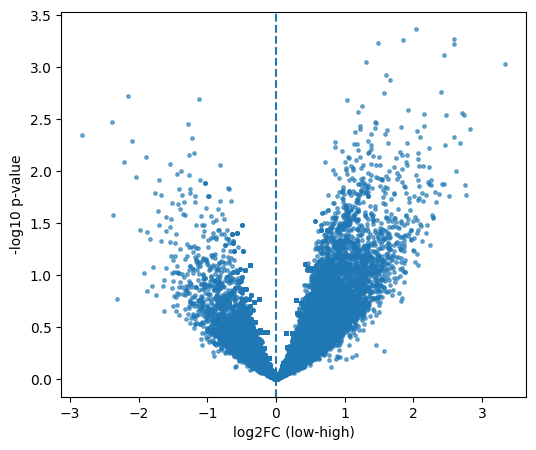

In [24]:
dfp = res.dropna(subset=['pvalue_ttest']).copy()
dfp['neglog10p'] = -np.log10(dfp['pvalue_ttest'])

plt.figure(figsize=(6,5))
plt.scatter(dfp['log2FC_G1G3_vs_G2G4'],dfp['neglog10p'],s=6,alpha=0.6)
plt.axvline(0,linestyle ='--')
plt.xlabel('log2FC (low-high)')
plt.ylabel('-log10 p-value')
plt.show